## Import and directories

In [1]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
# homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
# print('The data directory is homedir: %s' %homedir)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
download = r'/home/biswajit/Downloads'

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure


In [2]:
#Run this once to run the .py(Analysis_bis.py) file.
os.chdir(r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis')
%run Analysis.py
%run autocorrelate.py

In [3]:
matplotlib.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "10"
rc('axes', linewidth=1)
# plt.savefig('/home/biswajit/Downloads/test.svg', format='svg', transparent=True)

## Setup Schematic: Figure_1

## Time trace: Figure_2

In [40]:
def time_trace_plot(foldername= foldername, input_potential=[0, 25, 50, 100],
                    pointnumbers=[1], x_lim_min=0, y_lim_min=0, x_lim_max=5, y_lim_max=6, bin=5, show_changepoint=True, figsize=(10, 8)):
    """bin=1 in millisecond
    foldername should be given as r'D:\Research\...'
    """
    df_datn_emplot, df_FCS, folder = dir_mV_molNo(foldername)
    df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
    df_specific = df_specific[df_specific['Potential'].isin(input_potential)];
    df_specific=df_specific.sort(['Potential'], ascending=[1]);df_specific.reset_index(drop=True, inplace=True)
    fig, ax = plt.subplots(figsize = figsize,sharex=True, sharey=True)
    subplots_adjust(hspace=0.000);
    for i in range(len(df_specific)):
        given_potential = df_specific['Potential'][i]
        #print(given_potential)
        #df_specific_V = df_specific[df_specific['Potential'] == given_potential];df_specific_V.reset_index(drop=True, inplace=True)
        f_datn_path = df_specific['filepath[.datn]'][i]
        f_emplot_path = df_specific['filepath[.em.plot]'][i]
        f_datn = f_datn_path
        f_emplot = f_emplot_path

        ax = subplot(len(df_specific),1,i+1)
        df = pd.read_csv(f_datn, header=None)#Original data
        tt_length=max(df[0])-min(df[0])
        tt_length = round(tt_length, 0)
        binpts=tt_length*1000/bin
        df_hist = histogram(df[0], bins=binpts,range=(min(df[0]), max(df[0])))
        plot(df_hist[1][:-1], df_hist[0]/bin, 'b', label=str(given_potential)+" mV")#original data
        #----time trace overlapped with change-points
        if os.path.isfile(f_emplot):
            df = pd.read_csv(f_emplot, header=None, sep='\t') #change-point
            if show_changepoint == True:
                plot(df[0], df[1]*0.8/1000, 'r', linewidth=2, label='')#change-point analysis
        xlim(x_lim_min, x_lim_max)
        ylim(0, y_lim_max)# 1.5*max(df[1]/1000)
        # xticks([])
        yticks(range(0, y_lim_max, 2))
        if i == len(df_specific)-1:
            # xticks(range(0, x_lim_max+1, 1), fontsize=16)
            ax.set_xlabel('time/s')
        legend(framealpha=0.5)
    fig.text(0.04, 0.5, 'Fluorescence(kcps)', va='center', rotation='vertical')
    return(fig)

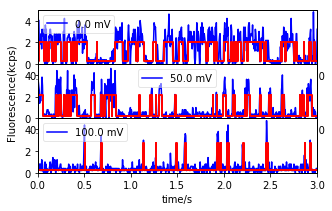

In [42]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
fig = time_trace_plot(foldername= folder, input_potential=[0, 50, 100], pointnumbers=[1], x_lim_min=0, y_lim_min=0,
                      x_lim_max=3, y_lim_max=5, bin=5, show_changepoint=True, figsize=(5, 3))
plt.savefig('/home/biswajit/Downloads/timetrace.svg', format='svg', dpi=300, transparent=True)

## Toff/Ton plot_Nernst fit: Figure_3a

In [12]:
def Mid_potentials_slopem(folderpath=foldername, pointnumbers=range(20), plotting=True, min_pot=40, min_pot_num=1):
    timetrace_output = timetrace_outputs_folderwise(folderpath=folderpath, pointnumbers=pointnumbers, potentialist=potentialist)
    def nernst(x, a):
        '''x is potential
        a: E0/midpoint potential(parameter)
        returns ratio(t_oxd/t_red)'''
        return(10**((x - a) / 0.059))
    def nernst_slopem(x, a, m):
        return(10**((x - a) / m))
    columns_E0 = ['Point number', 'E0_fit', 'E0_err']
    columns_E0_m = ['Point number', 'E0_fit', 'E0_err', 'slope', 'slope_error']
    E0_list = pd.DataFrame(index=None, columns=columns_E0)
    E0_m_list = pd.DataFrame(index=None, columns=columns_E0_m)
    #--figure initiation----
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(7,2.5))
        cmap = plt.get_cmap('jet')#jet_r
        N=len(timetrace_output.columns.levels[0])
    for i in range(len(timetrace_output.columns.levels[0])):
        point = timetrace_output.columns.levels[0][i]
        point_output_tot = timetrace_output[point].dropna()
        point_output = point_output_tot[point_output_tot['Potential'] >= min_pot] #select a potential threshold
        if len(point_output) > min_pot_num:
            potential = point_output['Potential']
            t_onav = point_output['t_onav']
            t_onaverr = point_output['t_onaverr']
            t_offav = point_output['t_offav']
            t_offaverr = point_output['t_offaverr']
            t_ratio = point_output['t_ratio']
            t_ratioerr = point_output['t_ratioerr']
            E = potential*0.001 #converting to mV
            #--------fitting nernst----------------
            E0_fit, E0_var = curve_fit(nernst, E, t_ratio, p0=0.02)
            E0_err = np.sqrt(np.diag(E0_var));
            E0 = E0_fit[0]; E0_err=E0_err[0]
            #---------append to list---------
            E0_list_temp = pd.DataFrame([[point, E0, E0_err]], columns=columns_E0)
            E0_list=E0_list.append(E0_list_temp, ignore_index=True)
            #--------fitting nernst_slopem------
            E0_m_fit, E0_m_var = curve_fit(nernst_slopem, E, t_ratio, p0=[0.02, 0.059])
            E0_m_err = np.sqrt(np.diag(E0_m_var))
            E0_m = E0_m_fit[0];E0_m_fit_err = E0_m_err[0];
            slope_m = E0_m_fit[1]; slope_m_err = E0_m_err[1];
            E0_m_list_temp = pd.DataFrame([[point, E0_m, E0_m_fit_err, slope_m, slope_m_err]], columns=columns_E0_m)
            E0_m_list = E0_m_list.append(E0_m_list_temp, ignore_index=True)
            #-----plot------
            if plotting == True:
                color = cmap(float(i)/N)
                axes[0].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[0].plot(linspace(-25, max(potential)+10), nernst(0.001*linspace(-25, max(potential)+10), *E0_fit), color=color, linewidth=2)#color
                axes[0].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                #plot(E*1000, nernst(E, *E0_fit), color=color, linewidth=2.0)

                
                axes[1].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[1].plot(linspace(-25, max(potential)+10), nernst_slopem(0.001*linspace(-25, max(potential)+10), *E0_m_fit), color=color, linewidth=2)
                axes[1].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                
                axes[0].set_yscale('log')
                axes[0].set_xlim(-25, 125)
                axes[0].set_xlabel('$Potential [V]$')
                axes[0].set_ylabel('$T_{OFF}/T_{ON}$')
                axes[0].tick_params(axis='both', which='major')
                #axes[0].set_title(r'$E=E_0 + 0.059log(\frac{t_{off}}{t_{on}})$')
                
                axes[1].set_yscale('log')
                axes[1].set_xlabel('$Potential [V]$')
                axes[1].set_ylabel('$T_{OFF}/T_{ON}$')
                axes[1].tick_params(axis='both', which='major')
                #axes[1].set_title(r'$E=E_0 + m.log(\frac{t_{off}}{t_{on}})$')
                axes[1].set_xlim(-25, 125)
                
                #from matplotlib.ticker import FormatStrFormatter
                #axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                #axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                #tight_layout()
                #legend(bbox_to_anchor=(0.9, 0.3), fontsize=16)
    return(E0_list, E0_m_list)

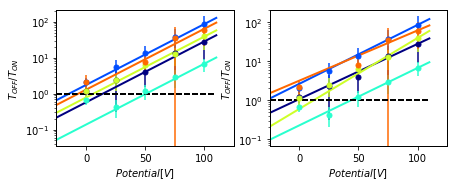

In [13]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
E0_list, E0_m_list = Mid_potentials_slopem(folderpath=folder, pointnumbers=[3, 4, 10, 14, 16], plotting=True, min_pot=25, min_pot_num=1)
savefig('/home/biswajit/Downloads/Nernstplot.svg', dpi=300, transparent=True)

## Histogram_E0: Figure_3b

In [14]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655]
#Calculate midpoint potential of all points in all folders
E0_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err'])
E0_m_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err', 'slope', 'slope_error'])
for folder in allfolders:
    E0_list, E0_m_list = Mid_potentials_slopem(folderpath=folder, pointnumbers=range(50), plotting=False, min_pot=25)
    E0_array = E0_array.append(E0_list, ignore_index=True)
    E0_m_array = E0_m_array.append(E0_m_list, ignore_index=True)

em.plot file: Point_0.11uW_A5_150mV(64)_7.pt3.datn.em.plot doesnt contain proper data
em.plot file of Point_2 with potential 100.0 doesnt exist
em.plot file of Point_14 with potential 45.0 doesnt exist
em.plot file of Point_15 with potential 100.0 doesnt exist


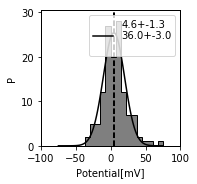

In [15]:
#MIDPOTENTIAL HISTGRAM FITTING/ PLOTTING
fig, axes = subplots(figsize=(2.5, 2.5))
E0_list = 1000*E0_array['E0_fit'] # Volt to mV
min_range = -75;
max_range = 75;
range_fit = [min_range, max_range]
bins = 20
bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points
def gaussian(x, a, b, c):
    return a*exp((-(x-b)**2)/(2*c**2))
n,bins_on1,patches = axes.hist(E0_list, bins = bins, range=range_fit, color='k', alpha=0.5, label='')#E0_list from running all folder
n,bins_on1,patches = axes.hist(E0_list, bins = bins, range=range_fit,color='k', histtype='step', label='')#E0_list from running all folder
y=n; x=bin_centers_on;
fit, pcov = curve_fit(gaussian, xdata=x, ydata=y, p0=[100, 5, 25], bounds=(0, np.inf))
perr = np.sqrt(np.diag(pcov));
center=round(fit[1], 1); center_err = round(perr[1], 1);
fwhm=round(2.3548*fit[2],1); fwhm_err = round(2.3548*perr[2],1);
height = fit[0]
E_fit_range = linspace(range_fit[0], range_fit[1], 100)
axes.plot(E_fit_range, gaussian(E_fit_range, *fit), 'k',label=str(center)+'+-'+str(center_err)+
          '\n'+str(fwhm)+'+-'+str(fwhm_err)+'\n')
axes.plot([center, center], [0, height+0.2*height], '--k', lw=2, label='')

axes.set_xlim(-100, 100)
axes.set_ylim(0,height+0.2*height)
axes.set_ylabel('P')
axes.set_xlabel('Potential[mV]')
axes.legend()

plt.savefig('/home/biswajit/Downloads/MidpointPotential_distribution.svg', format='svg', dpi=300, transparent=True)

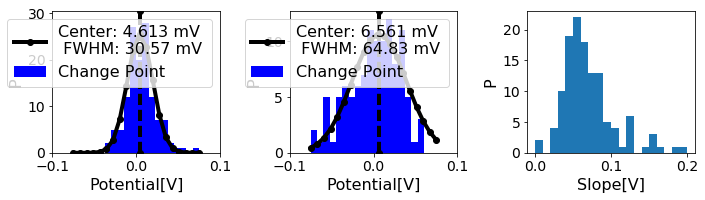

In [14]:
#MIDPOTENTIAL HISTGRAM FITTING
def plot_midpoint_hist(E0_array, E0_m_array):
    fig = plt.figure(figsize=(10, 3))
    # plt.figure()
    mpl.rcParams["font.family"] = "sans-serif"
    mpl.rcParams["font.size"] = "14"
    min_range = -0.075
    max_range = 0.075
    range_fit = [min_range, max_range]
    bins = 20
    bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
    x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points

    from scipy.interpolate import interp1d
    from lmfit.models import GaussianModel
    mod = GaussianModel()
    # params = gmodel.make_params(center=0.01, amplitude=10, sigma=0.02)
    #Change point--------------------------
    ax1 = fig.add_subplot(1,3,1)#2,2,1
    n,bins_on1,patches = ax1.hist(E0_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder
    y=n; x=bin_centers_on;
    result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
    temp =result1.best_values
    FWHM = 2*temp['sigma']*1000 #V
    cent = temp['center']*1000#eV
    amp = temp['amplitude']

    ax1.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
    amp = temp['amplitude']
    height = 0.3989423*amp/max(1.e-15, temp['sigma'])
    ax1.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

    ax1.set_xlim(-0.1, 0.1)
    ax1.set_ylim(0,height+0.2*height)
    ax1.set_ylabel('P', fontsize=16)
    ax1.set_xlabel('Potential[V]', fontsize=16)
    ax1.legend(fontsize=16)
    #-----
    ax2 = fig.add_subplot(1,3,2)
    n,bins_on1,patches = ax2.hist(E0_m_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder

    y=n; x=bin_centers_on;
    result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
    temp =result1.best_values
    FWHM = 2*temp['sigma']*1000 #V
    cent = temp['center']*1000#eV
    amp = temp['amplitude']

    ax2.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
    amp = temp['amplitude']
    height = 0.3989423*amp/max(1.e-15, temp['sigma'])
    ax2.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

    ax2.set_xlim(-0.1, 0.1)
    ax2.set_ylim(0,height+0.2*height)
    ax2.set_ylabel('P', fontsize=16)
    ax2.set_xlabel('Potential[V]', fontsize=16)
    ax2.legend(fontsize=16)
    #-----
    ax3 = fig.add_subplot(1,3,3)
    n,bins_on1,patches = ax3.hist(E0_m_array['slope'], bins = 20, range=(0, 0.2))#, range=range_fit, color='b', label='Change Point'
    # ax3.plot(E0_m_array['E0_fit']*1000, E0_m_array['slope'], )
    # ax3.set_xlim(-0.1, 0.1)
    # ax3.set_ylim(0,height+0.2*height)
    ax3.set_ylabel('P', fontsize=16)
    ax3.set_xlabel('Slope[V]', fontsize=16)
    # ax3.legend(fontsize=16)

    fig.tight_layout()
    # os.chdir(homedir)
    # fig.savefig('/home/biswajit/Pictures/canters_temp/MidpointPotential_distribution.pdf', dpi=300, transparent=True)
    # figure()
    # result.plot()
    return()
plot_midpoint_hist(E0_array, E0_m_array)
SI_figure=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure_SI'
os.chdir(SI_figure)
savefig('SI_potential_histogram_Cu.pdf', dpi=300, transparent=True)

## Many SM histogram

In [6]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';

Excluded_rate_analysis = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/Excluded_rate_analysis';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655, S105d15May17_60o5_635_A1_CuAzu655_longtime]

fold_201609 = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON, S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]
fold_201702 = [S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655];
fold_201705 = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

folder_50mV = [S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]#, S83d10Sept16_Cu_50mV_30s
folder_100mV = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON]

### on-off histogram

In [7]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=200, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], plotting=False):
    t_ons = []; t_offs = []; n_on = []; n_off = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot=f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    n_on,bins_on = histogram(t_ons, range=range_on,bins=bins_on);
    n_off,bins_off = histogram(t_offs, range=range_off,bins=bins_off)
    def risetime_fit(t, k1, k2, A):
        return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
    def mono_exp(t, k1, A):
        return A*exp(-k1*t)
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(6.3, 1.5)); #figsize
        #HIstogram with zoom in
        from mpl_toolkits.axes_grid.inset_locator import inset_axes
        #------------ON-histogram-------------------
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on,
                                           color='k', alpha=0.5, label='ON times')
        t=bins_on[:-1]; n = n_on[:];
        fit, pcov = curve_fit(mono_exp, t, n, p0=[10,1.1], bounds=(0, np.inf))
        print('k1:'+str(fit[0]))
        axes[0].plot(t, mono_exp(t, *fit), 'k',lw=2,label='k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[0].set_xlim(0, None)
        axes[0].set_yticks([])
        axes[0].set_xlabel(r'$\tau_{on}/s$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        #axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        #axes[0].legend()
        axes0_in = inset_axes(axes[0], height="50%", width="50%")
        axes0_in.hist(t_ons, range=[0, 0.04], bins=25, color='k', alpha=0.5, label='ON times');
        axes0_in.hist(t_ons, range=[0, 0.04], bins=25,color='k', histtype='step');
        axes0_in.set_xlim(0, None)
        axes0_in.set_yticks([])
        axes0_in.set_ylabel('#')
        #------------OFF-histogram-------------------
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off,
                                             color='k', alpha=0.5, label='ON times')
        t=bins_off[:-1]; n = n_off[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        print('k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[1].plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[1].set_xlim(0, None)
        axes[1].set_yticks([])
        axes[1].set_xlabel(r'$\tau_{off}/s$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        #axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
        #axes[1].legend()
        axes1_in = inset_axes(axes[1], height="50%", width="50%")
        axes1_in.hist(t_offs, range=[0, 0.15], bins=25,color='k', alpha=0.5, label='ON times');
        axes1_in.hist(t_offs, range=[0, 0.15], bins=25,color='k', histtype='step');
        axes1_in.set_xlim(0, None)
        axes1_in.set_yticks([]);
        axes1_in.set_ylabel('#')
        return(fig, t_ons, t_offs, n_on, bins_on, n_off, bins_off)
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist
k1:118.337770197
k1:4.43644774512
168.686132028


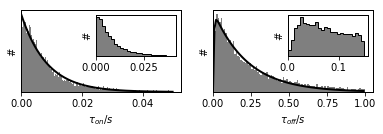

In [44]:
fig = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=200, range_on=[0, 0.05], bins_off=100, range_off=[0, 1], plotting=True);
savefig('/home/biswajit/Downloads/many_sm_hist.svg', format='svg', dpi=300, transparent=True)

In [ ]:
def hist_on_off_all_E0(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5],
                                bins_E0=200, plotting=False):
    t_ons = []; t_offs = []; n_on = []; n_off = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot=f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    n_on,bins_on = histogram(t_ons, range=range_on,bins=bins_on);
    n_off,bins_off = histogram(t_offs, range=range_off,bins=bins_off)
    def risetime_fit(t, k1, k2, A):
        return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
    if plotting == True:
        fig = plt.figure(figsize=(20,8));
        from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
        from mpl_toolkits.axes_grid1.inset_locator import mark_inset
        nrows=1; ncols= 3;
        ax00 = plt.subplot2grid((nrows,ncols), (0,0));
        ax01 = plt.subplot2grid((nrows,ncols), (0,1));
        ax02 = plt.subplot2grid((nrows,ncols), (0,2));
        #------------ON/OFF histogram-------------------
        n_on,bins_on,patches = ax00.hist(t_ons, range=range_on,bins=bins_on)
        t=bins_on[:-1]; n = n_on[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        ax00.plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1_on:'+str(int(fit[0]))+
                  '\n'+'k2_on:'+str(int(fit[1])))
        ax00.set_xlabel(r'$\tau_{on}/s$')
        ax00.set_ylabel('#')
        #axes[0].set_yscale('log')
        ax00.set_title("ON time histogram at %s mV" %input_potential[0])
        ax00.legend()
        ax00_in = zoomed_inset_axes(ax00, 6, loc=1)
        
        n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off)
        t=bins_off[:-1]; n = n_off[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        ax01.plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1_off:'+str(int(fit[0]))+
                  '\n'+'k2_off:'+str(int(fit[1])))
        ax01.set_xlabel(r'$\tau_{off}/s$')
        ax01.set_ylabel('#')
        #axes[1].set_yscale('log')
        ax01.set_title("OFF time histogram at %s mV" %input_potential[0])
        ax01.legend()
        #------------MidPoint potential-------------
        if len(t_ons)> len(t_offs):
            t_ons = t_ons[:len(t_offs)]
        else:
            t_offs = t_offs[:len(t_ons)]
        t_on_ratio = t_offs/t_ons
        E_0 = potential-59 * log10(t_on_ratio)
        ax02.hist(E_0, bins=bins_E0, range=(-200, 200))
        ax02.set_xlabel('Midpoint Potential/mV')
        ax02.set_ylabel('#')
        plt.close()
    return(fig)

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


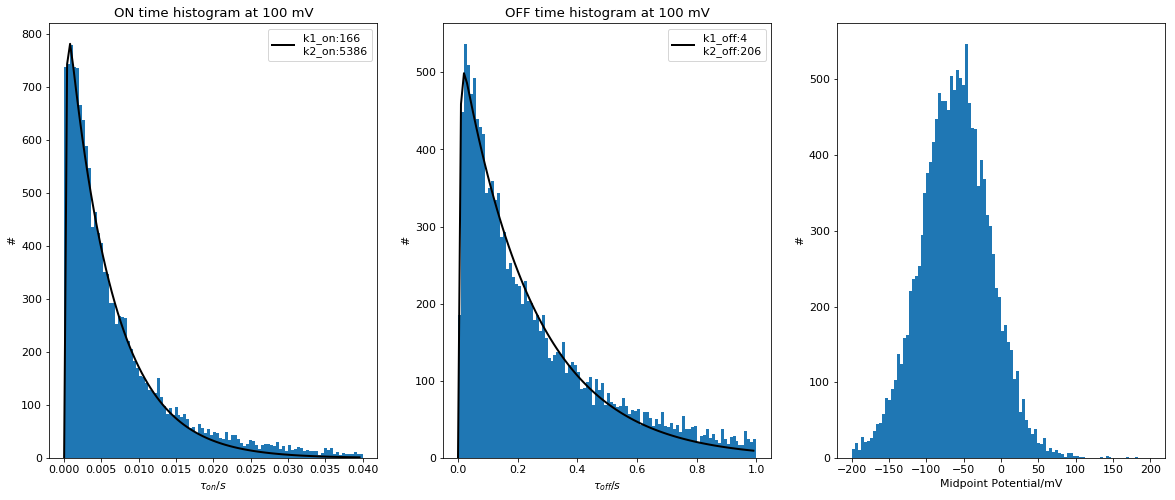

In [10]:
fig = hist_on_off_all_E0(folderlist = allfolders, input_potential=[100], pointnumbers=range(100), 
                        bins_on=100, range_on=[0, 0.04], bins_off=100, range_off=[0, 1],
                         bins_E0=100,plotting=True)

### Rate with potential

In [5]:
# list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';

Excluded_rate_analysis = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/Excluded_rate_analysis';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655, S105d15May17_60o5_635_A1_CuAzu655_longtime]
fold_201609 = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON, S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]
fold_201702 = [S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655];
fold_201705 = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

folder_50mV = [S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]#, S83d10Sept16_Cu_50mV_30s
folder_100mV = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON]

In [8]:
#hist all rates
def risetime_fit(t, k1, k2, A):
    return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
def mono_exp(t, k1, A):
    return A*exp(-k1*t)
columns=['potential','k1_on', 'k1_on_err', 'k1_off', 'k1_off_err', 'k2_off', 'k2_off_err']
df_k = pd.DataFrame(index=None, columns=columns);
df_on_of_hist = pd.DataFrame()
# fig, axes = plt.subplots(2,2, figsize = (12, 5))
potential_list = [100, 90, 80, 75, 70, 60, 50]
def hist_fit_rates(potential_list=[100, 90], folderlist=allfolders, df_k=df_k,
                   t_on_min=0, df_on_of_hist=df_on_of_hist):
    for i in range(len(potential_list)):
        potential=[potential_list[i]]
        t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= folderlist, input_potential=potential,
                                                                                    pointnumbers=range(100), bins_on=200, range_on=[0, 0.04], bins_off=400, range_off=[0, 1], plotting=False)
        # =========on-time fitting with mono_exp=========
        t=bins_on[t_on_min:-1]; n = n_on[t_on_min:]/max(n_on);
        fit, pcov = curve_fit(mono_exp, t, n, p0=[10,1.1], bounds=(0, np.inf))
        perr = np.sqrt(np.diag(pcov));
        n_fit = mono_exp(t, *fit)
        k1_on = fit[0]; k1_on_err = perr[0];
        fig, axes = plt.subplots(1,2, figsize = (12, 5))
        axes[0].plot(t, n, 'o',label=str(potential[0])+' mV')
        axes[0].plot(t, mono_exp(t, *fit), 'g',label='k1_on:'+str(int(k1_on)))
        axes[0].set_title("ON time histogram at different potential")
        axes[0].set_xlabel('On times')
        axes[0].set_ylabel('#')
        axes[0].legend()
        #save on-hist to df
        pot_col_name = str(potential[0])+' mV'+'_on';
        tim_col_name = 'time_on'+str(potential);
        fit_col_name = 'fit_on'+str(potential);
        df_on_of_hist[tim_col_name] = pd.Series(t, index=None);
        df_on_of_hist[pot_col_name] = pd.Series(n, index=None);
        df_on_of_hist[fit_col_name] = pd.Series(n_fit, index=None);
        # =========off-time fitting with mono_exp=========
        t=bins_off[:-1]; n = n_off/max(n_off)
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        n_fit = risetime_fit(t, *fit);
        perr = np.sqrt(np.diag(pcov));
        if fit[0]>fit[1]:
            k1_off=fit[0]; k1_off_err = perr[0];
            k2_off=fit[1]; k2_off_err = perr[1];
        else:
            k1_off=fit[1]; k1_off_err = perr[1];
            k2_off=fit[0]; k2_off_err = perr[0];
        axes[1].plot(t, n,'o', label=str(potential[0])+' mV')
        axes[1].plot(t, risetime_fit(t, *fit), 'g', label='k1_off:'+str(int(k1_off))+'\n'
                    +'k2_off:'+str(int(k2_off)))
        axes[1].set_title("OFF time histogram at different potential")
        axes[1].set_xlabel('On times')
        axes[1].set_ylabel('#')
        axes[1].legend()
        #save off-hist to df
        pot_col_name = str(potential[0])+' mV'+'_off';
        tim_col_name = 'time_off'+str(potential);
        fit_col_name = 'fit_off'+str(potential)
        df_on_of_hist[tim_col_name] = pd.Series(t, index=None);
        df_on_of_hist[pot_col_name] = pd.Series(n, index=None);
        df_on_of_hist[fit_col_name] = pd.Series(n_fit, index=None);
        
        columns=['potential','k1_on', 'k1_on_err', 'k1_off', 'k1_off_err', 'k2_off', 'k2_off_err']
        df_k_temp = pd.DataFrame([[potential[0], k1_on, k1_on_err, k1_off, k1_off_err, k2_off, k2_off_err]], columns=columns);
        df_k = df_k.append(df_k_temp, ignore_index=True)

        plt.close()
    return df_k, df_on_of_hist
##
df_k, df_on_of_hist = hist_fit_rates(potential_list=[100], folderlist=allfolders, df_k=df_k);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[80, 75], folderlist=allfolders, df_k=df_k);
# df_k, pdf, df_on_of_hist = hist_fit_rates(potential_list=[70], folderlist=allfolders, pdf=pdf, df_k=df_k, t_on_min=1);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[60], folderlist=allfolders, df_k=df_k);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[50], folderlist=allfolders, df_k=df_k, t_on_min=2);

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


In [11]:
df_k

,potential,k1_on,k1_on_err,k1_off,k1_off_err,k2_off,k2_off_err
0,100.0,154.882783,2.242361,135.420556,8.719136,4.144061,0.065156
1,80.0,94.173573,2.480511,335.239022,41.509601,5.067911,0.106656
2,75.0,106.950290,1.464968,265.625879,16.448283,5.328973,0.064846
3,60.0,57.094611,1.915068,251.926987,20.714298,6.535597,0.119558
4,50.0,39.499909,0.638602,571.767306,86.713075,7.798823,0.177509


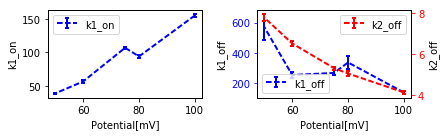

In [9]:
## df_k is obtained from previus cell
linestyle = {"linestyle":"--", "linewidth":2, "markeredgewidth":2, "elinewidth":2, "capsize":2};

fig1, axes = plt.subplots(1,2, figsize = (6.3, 2))
axes[0].errorbar(df_k['potential'], df_k['k1_on'], yerr=df_k['k1_on_err'], color='b', **linestyle, label='k1_on')
axes[0].set_xlabel('Potential[mV]')
axes[0].set_ylabel('k1_on')
# ax1_r = axes[0].twinx()
# ax1_r.plot(df_k['potential'], df_k['k2_on'], 'r-*', label='k2_on')
# ax1_r.tick_params('y', colors='r')

axes[1].errorbar(df_k['potential'], df_k['k1_off'], yerr=df_k['k1_off_err'], color='b', **linestyle, label='k1_off')
axes[1].set_xlabel('Potential[mV]')
axes[1].set_ylabel('k1_off')
axes[1].tick_params('y', colors='b')
ax2_r = axes[1].twinx()
ax2_r.errorbar(df_k['potential'], df_k['k2_off'], yerr=df_k['k2_off_err'], color='r', **linestyle, label='k2_off')
ax2_r.tick_params('y', colors='r')
ax2_r.set_ylabel('k2_off')
axes[0].legend(loc=2); axes[1].legend(loc=3);ax2_r.legend(loc=1)

fig1.tight_layout()
savefig('/home/biswajit/Downloads/k_rates_vs_potential.svg', format='svg', dpi=300, transparent=True)

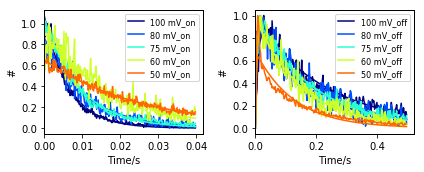

In [58]:
# df_on_of_hist is obtained 2-cells above
pot_len = shape(df_on_of_hist)[1]/6;
col_values = list(df_on_of_hist.columns.values);
fig_all_hist, axes = plt.subplots(1,2, figsize = (6, 2.5))
cmap = plt.get_cmap('jet')#jet_r
N=pot_len
for i in range(int(pot_len)):
    color = cmap(float(i)/N)
    j=6*i;
    axes[0].plot(df_on_of_hist.iloc[:,j], df_on_of_hist.iloc[:, j+1], color=color, label=col_values[j+1])
    axes[0].plot(df_on_of_hist.iloc[:,j], df_on_of_hist.iloc[:, j+2], color=color, label='')
    axes[0].set_xlim(0, None)
    axes[0].set_xlabel('Time/s')
    axes[0].set_ylabel('#')    
    axes[0].legend(fontsize=8)
    
    axes[1].plot(df_on_of_hist.iloc[:, j+3], df_on_of_hist.iloc[:, j+3+1], color=color, label=col_values[j+4])
    axes[1].plot(df_on_of_hist.iloc[:, j+3], df_on_of_hist.iloc[:,j+3+2], color=color, label='')
    axes[1].set_xlim(0, None)
    axes[1].set_xlabel('Time/s')
    axes[1].set_ylabel('#')    
    axes[1].legend(fontsize=8)
fig_all_hist.tight_layout()
os.chdir(download)
savefig('/home/biswajit/Downloads/rate_fit_all_potential.svg',format='svg', dpi=300, transparent=True)

## Ton_Toff Histogram: Figure 4

In [152]:
def histogram_on_off_1mol(foldername= foldername, input_potential=[100], pointnumbers=[1],
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False, sum_points=10):
    df_datn_emplot, df_FCS, folder = dir_mV_molNo(foldername)
    df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
    df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
    f_emplot_path = 'x'; f_datn_path='x'; t_ons=[];t_offs=[]
    if not df_specific.empty:
        f_datn_path = df_specific['filepath[.datn]'].values[0]
        f_emplot_path = df_specific['filepath[.em.plot]'].values[0]
    if os.path.isfile(f_emplot_path):
        df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot_path)
        t_ons = np.array(df_ton);
        t_offs = np.array(df_toff)
        n_on = []; n_off = []
        if plotting == True:
            fig = plt.figure(figsize=(6.3, 8))
            nrows=4; ncols= 2;
            ax00 = plt.subplot2grid((nrows,ncols), (0,0));
            ax01 = plt.subplot2grid((nrows,ncols), (0,1));
            ax1 = plt.subplot2grid((nrows, ncols), (1,0), colspan=2)
            ax2 = plt.subplot2grid((nrows, ncols), (2,0), colspan=2)
            ax30 = plt.subplot2grid((nrows, ncols), (3,0))
            ax31 = plt.subplot2grid((nrows, ncols), (3,1))
            #ax3 = plt.subplot2grid((nrows, ncols), (3,0), colspan=2)

            n_on,bins_on,patches = ax00.hist(t_ons, range=range_on, bins=bins_on, color='k', alpha=0.5, label='ON times')
            n_on,bins_on,patches = ax00.hist(t_ons, range=range_on, bins=bins_on, color='k', histtype='step')
            ax00.set_xlabel(r'$\tau_{on}/s$')
            ax00.set_ylabel('PDF')
            ax00.set_xlim(0, None)
            ax00.yaxis.set_ticklabels([])
            ax00.legend()
            #ax00.set_yscale('log')
            n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off, color='k', alpha=0.5, label='OFF times')
            n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off, color='k', histtype='step')
            ax01.set_xlabel(r'$\tau_{off}/s$')
            ax01.yaxis.set_ticklabels([])
            ax01.set_xlim(0, None)
            ax01.legend()
            #ax01.set_yscale('log')
            #ax01.set_title("OFF time histogram at %s mV" %input_potential[0])
            if len(t_ons)> len(t_offs):
                t_ons = t_ons[:len(t_offs)]
            else:
                t_offs = t_offs[:len(t_ons)]

            t_av_on = []; t_av_off = []; t_abs = [];
            start=0;
            num_outputs = int(len(t_ons)/sum_points);
            for i in range(num_outputs):
                t_av_on_temp = sum(t_ons[start:start+sum_points])/sum_points
                t_av_of_temp = sum(t_offs[start:start+sum_points])/sum_points
                start += sum_points
                t_av_on.append(t_av_on_temp)
                t_av_off.append(t_av_of_temp)
                t_abs_temp = sum(t_ons[:start+sum_points]) + sum(t_offs[:start+sum_points])
                t_abs.append(t_abs_temp)
            t_av_on = pd.Series(t_av_on);
            t_av_off = pd.Series(t_av_off)

            t_on_ratio = t_av_off/t_av_on;

            ax1.plot(t_abs, t_av_on, 'b', label='On_av')
            ax1.set_ylim(-0.01, 0.02)#CAREFUL
            ax1.set_xlim(0, None)
            ax1.tick_params('y', colors='b')
            ax1.set_ylabel('ton_av/s', color='b')
            #ax1.set_xticks([])
            ax1.legend(loc='center right')
            ax1_r = ax1.twinx()
            
            ax1_r.plot(t_abs, t_av_off, 'r',label='Off_av')
            ax1_r.tick_params('y', colors='r')
            ax1_r.set_ylabel('toff_av/s', color='r')
            ax1_r.set_ylim(0, 1)#BE CAREFUL of this limit
            ax1_r.set_xlim(0, None)
            #ax1_r.set_xlabel('time/s')
            #ax1_r.set_xticks([])
            ax1_r.legend(loc='center')
            # Autocorrelation
            try:
                m=(len(t_av_on)/2)-5;
                t_av_tot = average(t_av_on)+average(t_av_off);
                G = autocorrelate(t_av_on[:-1], m=m ,deltat=1,normalize=True);
                ax30.plot(G[:,0]*t_av_tot, G[:,1], 'b',label='On time correlation')
                ax30.set_xscale('log')
                ymax_lim = G[1]
                ax30.set_ylim(-0.01, ymax_lim[1]+0.1*ymax_lim[1])

                #ax30.set_title("ON time dynamic corr at\n %s mV of Point_%s" %(input_potential, pointnumbers))
                #ax30.set_ylim(0, None)
                ax30.legend()
                #off-time correlation-------
                m=(len(t_av_off)/2)-5;
                G = autocorrelate(t_av_off[:-1], m=m ,deltat=1,normalize=True);
                ax30.plot(G[:,0]*t_av_tot, G[:,1], 'r',label='Off time correlation')
                ax30.set_xscale('log')
                ax30.set_xlabel('time/s')
                ax30.set_ylabel('G(t)')
                ymax_lim = G[1]
                ax30.set_ylim(-0.01, ymax_lim[1]+0.5*ymax_lim[1])
                #ax30.set_title("OFF time dynamic corr\n at %s mV of Point_%s" %(input_potential, pointnumbers))
                ax30.legend()
            except:
                pass       
            potential = input_potential[0]
            E_0 = potential-59 * log10(t_on_ratio)
            ax2.plot(t_abs, E_0, label='E_0')
            ax2.set_xlim(0, None)
            ax2.set_ylabel('E_0/mV')
            ax2.set_xlabel('time/s')
            bins=40; range_fit = [-150, 150];
            bin_centers = linspace(range_fit[0], range_fit[1], bins);

            n, bins_hist, patches = ax31.hist(E_0, bins=bins, range=range_fit)
            y=n; x=bin_centers;

            # plot(x, y)
            def gaussian(x, a, b, c):
                return a*exp((-(x-b)**2)/(2*c**2))
            fit, pcov = curve_fit(gaussian, xdata=x, ydata=y, p0=[100, 5, 25], bounds=(0, np.inf))
            perr = np.sqrt(np.diag(pcov));
            center=round(fit[1], 1); center_err = round(perr[1], 1);
            fwhm=round(2.3548*fit[2],1); fwhm_err = round(2.3548*perr[2],1);
            #print('Center is %.1f and fwhm is %.1f' %(center, fwhm))
            E0_fitrange = linspace(range_fit[0], range_fit[1], 100);
            ax31.plot(E0_fitrange, gaussian(E0_fitrange, *fit), label=str(center)+'+-'+str(center_err)+'\n'+
                                            str(fwhm)+'+-'+str(fwhm_err)+'\n')
            ax31.set_xlabel('Midpoint Potential/mV')
            ax31.set_ylabel('#')
            ax31.set_xlabel(r'$E_0/mV$')
            ax31.set_xlim(-100, 100)
            ax31.legend()
#             fig.tight_layout()
    return(t_av_on, t_av_off, G)

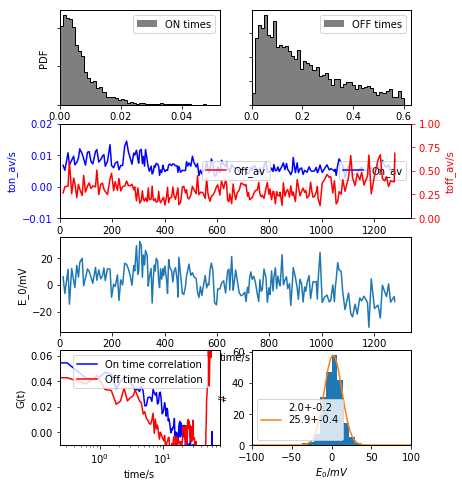

In [15]:
mpl.rcParams["font.size"] = "10"
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';#data directory
t_av_on, t_av_off, G = histogram_on_off_1mol(foldername= homedir, input_potential=[100], pointnumbers=[26],
                                                                      bins_on=50, range_on=[0, 0.05], bins_off=50, range_off=[0, 0.6], plotting=True, sum_points=20)
savefig('/home/biswajit/Downloads/SM_statistics.svg', format='svg', dpi=300, transparent=True);
mpl.rcParams["font.size"] = "10"

### No of averaging points

In [17]:
#E_0 from each molecule
def single_azurin_hist(foldername= foldername, input_potential=[100], pointnumbers=[1],bin_trace=5,
                          bins_on=100, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], show_changepoint=False, sum_points=10):
    df_datn_emplot, df_FCS, folder = dir_mV_molNo(foldername)
    df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
    df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
    #f_emplot_path = 'x'; f_datn_path='x'; t_ons=[];t_offs=[];n_on = []; n_off = []
    fig=0;#returns zero if the file not found
    t_av_on=[]; t_av_off=[]; t_abs = []
    if not df_specific.empty:
        f_datn_path = df_specific['filepath[.datn]'].values[0]
        f_emplot_path = df_specific['filepath[.em.plot]'].values[0]
        if os.path.isfile(f_emplot_path):
            #----------fig properties-----------
            fig = plt.figure(figsize=(8, 16));
            mpl.rcParams["font.family"] = "sans-serif"
            mpl.rcParams["font.size"] = "11"
            colormap=mpl.cm.RdBu_r
            nrows=6; ncols=2;
            ax0 = plt.subplot2grid((nrows,ncols), (0,0), colspan=2);
            ax10 = plt.subplot2grid((nrows,ncols), (1,0));
            ax11 = plt.subplot2grid((nrows,ncols), (1,1));
            ax2 = plt.subplot2grid((nrows,ncols), (2,0), colspan=2);
            ax3 = plt.subplot2grid((nrows,ncols), (3,0), colspan=2);
            ax40 = plt.subplot2grid((nrows,ncols), (4,0));
            ax41 = plt.subplot2grid((nrows,ncols), (4,1));
            ax50 = plt.subplot2grid((nrows,ncols), (5,0));
            ax51 = plt.subplot2grid((nrows,ncols), (5,1));
            #-------------tIME TRACE ax0------------
            ax0.set_title('Point number: '+str(pointnumbers)+' at '+str(input_potential)+' mV', fontsize=20)
            df = pd.read_csv(f_datn_path, header=None)#Original data
            tt_length=max(df[0])-min(df[0])
            tt_length = round(tt_length, 0)
            binpts= tt_length*1000/bin_trace
            df_hist = histogram(df[0], bins=binpts,range=(min(df[0]), max(df[0])))
            ax0.plot(df_hist[1][:-1], df_hist[0]/bin_trace, 'b', label=str(input_potential[0])+" mV")#original data
            if show_changepoint==True:
                df = pd.read_csv(f_emplot_path, header=None, sep='\t') #change-point
                ax0.plot(df[0], df[1]*0.8/1000, 'r', linewidth=2, label='')#change-point analysis
            ax0.set_xlabel('Time/s')
            ax0.set_xlim(min(df[0]), max(df[0]))
            ax0.set_ylabel('Counts(kcps)')
            # -----------ON OFF histogram; ax10, ax11-----------
            df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot=f_emplot_path);
            t_ons = np.array(df_ton);t_offs = np.array(df_toff)
            n_on,bins_on,patches = ax10.hist(t_ons, range=range_on, bins=bins_on, color='k', alpha=0.5)
            n_on,bins_on,patches = ax10.hist(t_ons, range=range_on, bins=bins_on, color='k', histtype='step')
            ax10.set_xlim(0, None)
            ax10.set_xlabel(r'$\tau_{on}/s$')
            ax10.set_ylabel('#')
            n_off,bins_off,patches = ax11.hist(t_offs, range=range_off,bins=bins_off, color='k', alpha=0.5)
            n_off,bins_off,patches = ax11.hist(t_offs, range=range_off,bins=bins_off, color='k', histtype='step')
            ax11.set_xlim(0, None)
            ax11.set_xlabel(r'$\tau_{off}/s$')
            #-----------traces of rates (ON / OFF); ax2, ax3-------
            sum_points = sum_points;# no of points to average (for on and off times)
            num_outputs = int(len(t_ons)/sum_points)
            start = 0;
            t_av_on = []; t_av_off = []; t_abs = [];
            for i in range(num_outputs):
                t_av_on_temp = sum(t_ons[start:start+sum_points])
                t_av_of_temp = sum(t_offs[start:start+sum_points])
                start += sum_points
                t_av_on.append(t_av_on_temp)
                t_av_off.append(t_av_of_temp)
                t_abs_temp = sum(t_ons[:start+sum_points]) + sum(t_offs[:start+sum_points])
                t_abs.append(t_abs_temp)
            t_av_on = pd.Series(t_av_on);
            t_av_off = pd.Series(t_av_off)
            ax2.plot(t_abs, t_av_on, 'b', label='On_av('+str(sum_points)+'events)')
            ax2.set_ylim(0, None)
            ax2.set_xlim(0, None)
            ax2.tick_params('y', colors='b')
            ax2.set_ylabel('ton_av/s', color='b')
            ax2.set_xticks([])
            ax2.legend()
            ax3.plot(t_abs, t_av_off, 'r',label='Off_av('+str(sum_points)+'events)')
            ax3.tick_params('y', colors='r')
            ax3.set_ylabel('toff_av/s', color='r')
            ax3.set_ylim(0, None)#BE CAREFUL of this limit
            ax3.set_xlim(0, None)
            ax3.set_xlabel('time/s')
            ax3.legend()
            #----------ON-OFF 2D hist & Midpoint potential; ax40, ax41------------
            ontimes = t_av_on[:-10];
            offtimes = t_av_off[:-10];
            if len(ontimes)> len(offtimes):
                ontimes = ontimes[:len(offtimes)]
            else:
                offtimes = offtimes[:len(ontimes)]
            if len(t_ons)> len(t_offs):
                t_ons = t_ons[:len(t_offs)]
            else:
                t_offs = t_offs[:len(t_ons)] 
            ax40.hist2d(t_ons, t_offs, bins=40, range=([0, 0.1], [0, 0.5]), cmap=colormap);
            ax40.set_ylabel(r'$\tau_{on}/s$')
            ax40.set_ylabel(r'$\tau_{off}/s$')
            t_on_ratio = offtimes/ontimes;
            E_0 = potential-59 * log10(t_on_ratio)
            ax41.hist(E_0, bins=40, range=(-150, 150))
            ax41.set_xlabel('Midpoint Potential/mV')
            ax41.set_ylabel('#')
            ax41.set_xlabel(r'$E_0[mV]$')
            #-----------correlation of traces of rates; ax50, ax51------------- 
            try:
                m=(len(t_av_on)/2)-5;
                G = autocorrelate(t_av_on[:-1], m=m ,deltat=1,normalize=True);
                ax50.plot(G[:,0], G[:,1], 'b',label='On time correlation')
                ax50.set_xscale('log')
                ymax_lim = G[1]
                ax50.set_ylim(-0.01, ymax_lim[1]+0.1*ymax_lim[1])

                #ax50.set_title("ON time dynamic corr at\n %s mV of Point_%s" %(input_potential, pointnumbers))
                #ax50.set_ylim(0, None)
                ax50.legend()
                #off-time correlation-------
                m=(len(t_av_off)/2)-5;
                G = autocorrelate(t_av_off[:-1], m=m ,deltat=1,normalize=True);
                ax51.plot(G[:,0], G[:,1], 'r',label='Off time correlation')
                ax51.set_xscale('log')
                ymax_lim = G[1]
                ax51.set_ylim(-0.01, ymax_lim[1]+0.1*ymax_lim[1])
                #ax51.set_title("OFF time dynamic corr\n at %s mV of Point_%s" %(input_potential, pointnumbers))
                ax51.legend()
            except:
                pass
        #fig.tight_layout() #figsize=(20, 10)
        plt.close()
    return fig, t_abs, t_av_on, t_av_off

S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
Excluded_rate_analysis = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/Excluded_rate_analysis';
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

cols=['sum_points' ,'center', 'center_err', 'fwhm', 'fwhm_err']
df = pd.DataFrame(columns=cols);
df_E0_n = pd.DataFrame()
for i in range(50):
    sum_points = i+1
    long_trace_files = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime, Excluded_rate_analysis, S83d10Sept16_Cu_50mV_300s];
    fig, t_abs, t_av_on, t_av_off = single_azurin_hist(foldername=S106d18May17_635_CuAzu655_longtime, input_potential=[100], pointnumbers=[26], sum_points=sum_points)
    # fig
    plt.figure()
    potential=100;
    t_on_ratio = t_av_off/t_av_on;
    E_0 = potential-59 * log10(t_on_ratio)
    sum_points_colname = 'n_' + str(sum_points);
    t_abs_colname = 't_abs' + str(sum_points)
    df_E0_n_temp = pd.DataFrame({t_abs_colname: t_abs,
                                sum_points_colname: E_0})
    df_E0_n = pd.concat([df_E0_n, df_E0_n_temp], axis=1)
    #===histogram and fitting====
    bins=40; range_fit = [-150, 150];
    bin_centers = linspace(range_fit[0], range_fit[1], bins);

    n, bins_hist, patches = hist(E_0, bins=bins, range=range_fit)
    y=n; x=bin_centers;

    # plot(x, y)
    def gaussian(x, a, b, c):
        return a*exp((-(x-b)**2)/(2*c**2))
    fit, pcov = curve_fit(gaussian, xdata=x, ydata=y, p0=[100, 5, 25], bounds=(0, np.inf))
    perr = np.sqrt(np.diag(pcov));
    center=round(fit[1], 1); center_err = round(perr[1], 1);
    fwhm=round(2.3548*fit[2],1); fwhm_err = round(2.3548*perr[2],1);
    df_temp = pd.DataFrame([[sum_points, center, center_err, fwhm, fwhm_err]], columns=cols);
    df = df.append(df_temp, ignore_index=True)
    #print('Center is %.1f and fwhm is %.1f' %(center, fwhm))
    plot(x, gaussian(x, *fit), label=str(center)+'+-'+str(center_err)+'\n'+
                                    str(fwhm)+'+-'+str(fwhm_err)+'\n')
    xlabel('Midpoint Potential/mV')
    ylabel('#')
    xlabel(r'$E_0[mV]$')
    legend()
    savefig('/home/biswajit/Downloads/gaussianfit/'+'sumpoints_'+str(i)+'.png')
    plt.close()
# df

0
2
4
8
18
38
58


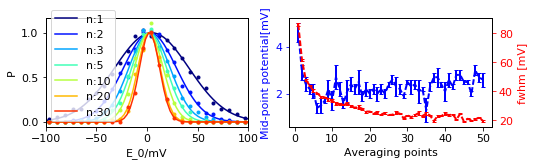

In [85]:
# df: fit values and parameters were obtained in previous cell
fig = plt.figure(figsize=(8, 2))
nrows=1;ncols=2;
ax00 = plt.subplot2grid((nrows, ncols), (0,0))
ax01 = plt.subplot2grid((nrows, ncols), (0,1))
linestyle = {"linestyle":"--", "linewidth":2, "markeredgewidth":1, "elinewidth":2, "capsize":2}
tickstyle = {"direction":"in", "width":2, "color":'b'}
rc('axes', linewidth=1)

#E_0 hist as function of sum_points
cmap = plt.get_cmap('jet')#jet_r
n_list = [1, 2, 3, 5, 10, 20, 30]
for i in range(len(n_list)):
    n = 2*n_list[i]-2;
    print(n)
    color = cmap(i/len(n_list))
    E0_n = df_E0_n.ix[:,n].replace([np.inf, -np.inf], np.nan).dropna()
    E0_n = E0_n.values
    bins=40; range_fit = [-150, 150];
    bin_centers = linspace(range_fit[0], range_fit[1], bins);
    N, bins_hist = np.histogram(E0_n, bins=bins, range=range_fit)
    y=N; x=bin_centers;
    def gaussian(x, a, b, c):
        return a*exp((-(x-b)**2)/(2*c**2))
    fit, pcov = curve_fit(gaussian, xdata=x, ydata=y, p0=[100, 5, 25], bounds=(0, np.inf))
    perr = np.sqrt(np.diag(pcov));
    center=round(fit[1], 1); center_err = round(perr[1], 1);
    fwhm=round(2.3548*fit[2],1); fwhm_err = round(2.3548*perr[2],1);
    E0_fitrange = linspace(range_fit[0], range_fit[1], 100);
    E0_fitvalues = gaussian(E0_fitrange, *fit)
    ax00.plot(bin_centers, y/max(E0_fitvalues), '.', color=color)
    ax00.plot(E0_fitrange, E0_fitvalues/max(E0_fitvalues),color=color , label='n:'+str(n_list[i]))
ax00.set_xlim(-100, 100)
ax00.set_xlabel('E_0/mV')
ax00.set_ylabel('P')
ax00.legend()

ax01.errorbar(df['sum_points'], df['center'], yerr=df['center_err'], color='b', **linestyle)
ax01.set_ylabel('Mid-point potential[mV]', color='b')
ax01.tick_params('y', colors='b')

ax_r = twinx(ax01);
ax_r.errorbar(df['sum_points'], df['fwhm'],yerr=df['fwhm_err'], color='r', **linestyle)
ax_r.set_ylabel('fwhm [mV]', color='r')
ax_r.tick_params('y', colors='r')
ax01.set_xlabel('Averaging points')
plt.savefig('/home/biswajit/Downloads/N_avgpoints_vs_fwhmwidth.svg', format='svg', dpi=300, transparent=True)
# df_E0_n.ix[:,[0,1]]

### 100mV : Point_26/ 1200 s

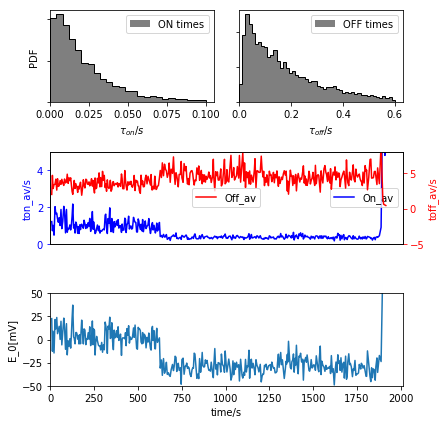

In [240]:
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=[50], pointnumbers=[16],
                                                                      bins_on=25, range_on=[0, 0.1], bins_off=50, range_off=[0, 0.6], plotting=True, sum_points=20)
os.chdir(download)
savefig('SM_statistics.pdf', dpi=300, transparent=True)

## Ton_Toff histogram: 2D: Figure_5

Number of on events: 7896
Number of off events: 7894


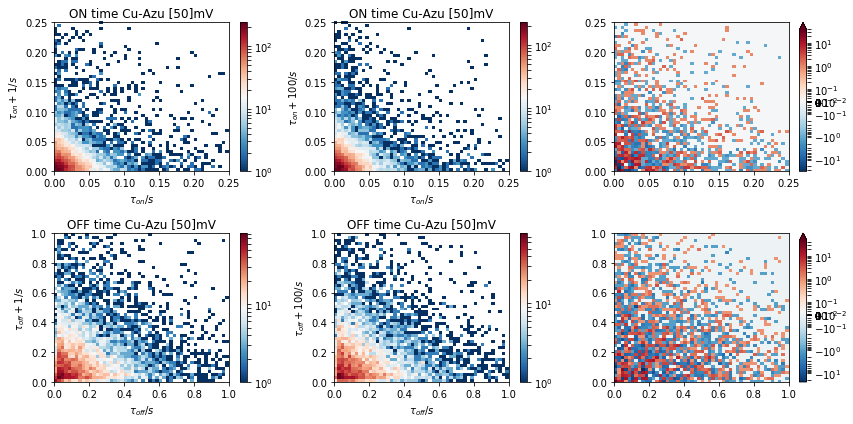

In [43]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "10"
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
C_on_diff, C_off_diff = hist2D_on_off(foldername=homedir, input_potential=[50], pointnumbers=[16], bins_on=20, range_on=[0, 0.25],
                                      bins_off=20, range_off=[0, 1], x_shift=100, plots=True, figsize=(12, 6))
os.chdir(download)
savefig('Figure_4part_on_off_2D_100mV.pdf', dpi=300, transparent=True)

## Dynamics rate

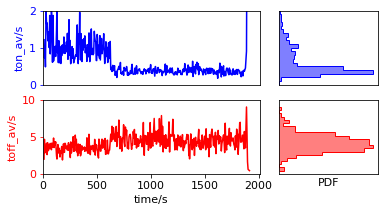

In [34]:
#dynamics from the same trace
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=[50], pointnumbers=[16],
                          bins_on=50, range_on=[0, 0.01], bins_off=100, range_off=[0, 1], plotting=False)

sum_points = 20;
num_outputs = int(len(t_ons)/sum_points)
start = 0;
t_av_on = []; t_av_off = []; t_abs = [];
for i in range(num_outputs):
    t_av_on_temp = sum(t_ons[start:start+sum_points])
    t_av_of_temp = sum(t_offs[start:start+sum_points])
    start += sum_points
    t_av_on.append(t_av_on_temp)
    t_av_off.append(t_av_of_temp)
    t_abs_temp = sum(t_ons[:start+sum_points]) + sum(t_offs[:start+sum_points])
    t_abs.append(t_abs_temp)
t_av_on = pd.Series(t_av_on);
t_av_off = pd.Series(t_av_off)

figure(figsize=(6, 3))
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "11"

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, label='ax1')
ax1.plot(t_abs, t_av_on, 'b')
ax1.set_ylim(0, 2)
ax1.set_xlim(0, None)
ax1.tick_params('y', colors='b')
ax1.set_ylabel('ton_av/s', color='b')
ax1.set_xticks([])
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax2.hist(t_av_on,bins=20, range=(0,2), orientation='horizontal', color='b', alpha=0.5)
ax2.hist(t_av_on,bins=20, range=(0,2), orientation='horizontal', color='b', histtype='step', lw=1)
ax2.set_ylim(0, 2)
ax2.set_xticks([]); ax2.set_yticks([])

ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
ax3.plot(t_abs, t_av_off, 'r')
ax3.tick_params('y', colors='r')
ax3.set_ylabel('toff_av/s', color='r')
ax3.set_ylim(0, 10)#BE CAREFUL of this limit
ax3.set_xlim(0, None)
ax3.set_xlabel('time/s')
ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.hist(t_av_off,bins=20, orientation='horizontal', color='r', alpha=0.5)
ax4.hist(t_av_off,bins=20, orientation='horizontal', color='r', histtype='step', lw=1)
ax4.set_xticks([]); ax4.set_yticks([])
ax4.set_ylim(0, 10)#BE CAREFUL of this limit
ax4.set_xlabel('PDF')
# tight_layout()
os.chdir(download)
savefig('dynamic_rates.pdf', dpi=300, trasparent = True)

## Life time

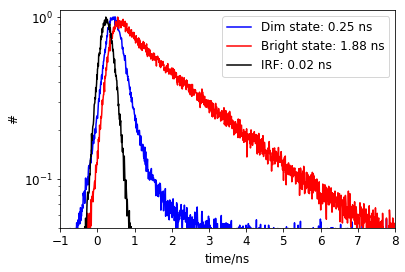

In [136]:
#lifetime
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/lifetime')
file_oxd='Point_A1_100mV(10)_60.5_1200s_24_lifetime_oxd.dat'
file_red='Point_A1_050mV(7)_60.5_1920s_16_reduced.dat'
file_irf = 'irf_20170511_lowpower.dat'
file_Zn = 'Point_A5_025mV(29)_60.5_260s_10_Zn_lifetiem.dat'
d_oxd= pd.read_csv(file_oxd, header=None, sep='\t', skiprows=10)
d_red = pd.read_csv(file_red, header=None, sep='\t', skiprows=10)
d_irf = pd.read_csv(file_irf, header=None, sep='\t', skiprows=10)
d_Zn = pd.read_csv(file_Zn, header=None, sep='\t', skiprows=10)
x_offset = 4.5;
fig, ax = plt.subplots(figsize=(6,4))
mpl.rcParams["font.family"] = "sans-serif"
fontsize = 12
ax.plot(d_oxd[0]-x_offset, d_oxd[2]/max(d_oxd[2]), 'b', label='Dim state: 0.25 ns')
ax.plot(d_red[0]-x_offset, d_red[2]/max(d_red[2]), 'r', label='Bright state: 1.88 ns')
ax.plot(d_irf[0]-x_offset, d_irf[2]/max(d_irf[2]), 'k', label='IRF: 0.02 ns')
# ax.plot(d_Zn[0]-x_offset, d_Zn[2]/max(d_Zn[2]), 'g', label='ZnAzurin: 2.1 ns')
ax.set_yscale('log')
ax.set_xlim(-1, 8)
ax.set_ylim(0.05, 1.1)
ax.set_xlabel('time/ns', fontsize=fontsize)
ax.set_ylabel('#', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
os.chdir(download)
savefig('lifetime.pdf', dpi=300, transparent=True)

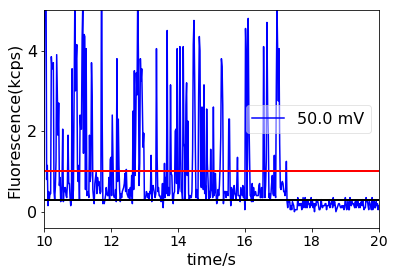

In [153]:
#corresponding time trace
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "14"
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/lifetime'
fig = time_trace_plot(foldername= folder, input_potential=[50], pointnumbers=[3], x_lim_min=10, y_lim_min=0,
                      x_lim_max=20, y_lim_max=5, bin=20, show_changepoint=False, figsize=(6,4))
plot(linspace(10,20,10), ones(10)*1, 'r', lw=2, label='threshold')
plot(linspace(10,20,10), ones(10)*0.3, 'k', lw=2, label='threshold')
ylim(-0.4, None)
# legend(fontsize = 16)
os.chdir(download)
savefig('lifetime_timetrace.pdf', dpi=300, transparent=True)

## Image

In [105]:
# Image at oxidizing and redux-cing condition
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/image')
f_oxd = 'S81d7Sept16_0.53uW_0.2mMFerri_0.1mM Asc_200mV(22)_A2_again.dat';
f_red = 'S81d7Sept16_0.53uW_0.2mMFerri_0.1mM Asc_-50mV(23)_A2_again.dat';
d_oxd= pd.read_csv(f_oxd, header=None, sep='\s+', skiprows=8)
d_red= pd.read_csv(f_red, header=None, sep='\s+', skiprows=8)
# d_oxd
fig, axes = plt.subplots(2,1,figsize=(4,8))
color = "hot"
axes[0].imshow(d_oxd, cmap=color, vmin=0, vmax=20, aspect='equal')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(d_red, cmap=color, vmin=0, vmax=20, aspect='equal')
axes[1].set_xticks([])
axes[1].set_yticks([])
os.chdir(download)
savefig('image_onoff.pdf', dpi=300, transparent=True)

## fcs components

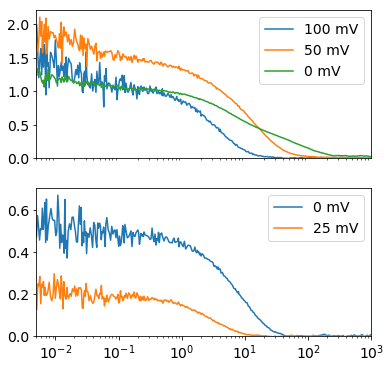

In [194]:
#fcs components
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/fcs_component/');
f_100 = 'Point_A9_100mV(18)_60.5_1600s_26_FCS1.dat';
f_50 = 'Point_A8_050mV(15)_60.5_1980s_22_FCS1.dat';
f_0 = 'Point_A6_000mV(9)_60.5_1260s_10_FCS1.dat';
f_Zn_0 = 'Point_0.11uW_A3_ZnAzu_0mV(21)_200sec_27_FCS1.dat';
f_Zn_25 = 'Point_A5_ZnAzu_025mV(29)_60.5_260s_10_FCS1.dat';
#----
tmin = 0.005;tmax = 1000;
fig, axes = plt.subplots(2,1, figsize=(6, 6))
#---100 mV
df_fcs = pd.read_csv(f_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_100[0],f_100[1], '-', label='100 mV')
#---50 mV
df_fcs = pd.read_csv(f_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_50[0],f_50[1], '-', label='50 mV')
#---
df_fcs = pd.read_csv(f_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_0[0],f_0[1], '-', label='0 mV')

axes[0].set_xscale('log')
axes[0].set_ylim(0, None)
axes[0].set_xlim(tmin, tmax)
axes[0].set_xticks([])
axes[0].legend()
#--ZnAzu 0 mV---
df_fcs = pd.read_csv(f_Zn_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_0[0],f_Zn_0[1], '-', label='0 mV')
#ZnAzu 25 mV---
df_fcs = pd.read_csv(f_Zn_25, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_25 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_25[0],f_Zn_25[1], '-', label='25 mV')

axes[1].set_xscale('log')
axes[1].set_ylim(0, None)
axes[1].set_xlim(tmin, tmax)
axes[1].legend()

os.chdir(download)
savefig('fcs_components.pdf', dpi=300, transparent=True)

## fcs comparision

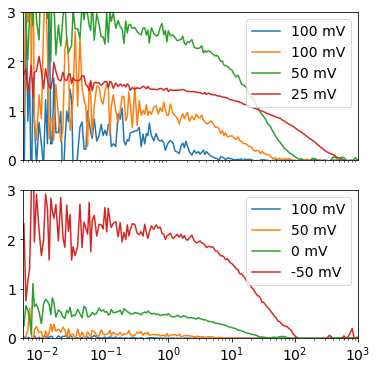

In [195]:
#fcs components
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/fcs_comparision/');
# CuAzurin files
f_Cu_150 = 'CuAzu/Point_0.11uW_A3_150mV_6_FCS1.dat';
f_Cu_100 = 'CuAzu/Point_0.11uW_A3_100mV_6_FCS1.dat';
f_Cu_50 = 'CuAzu/Point_0.11uW_A3_50mV_6_FCS1.dat';
f_Cu_25 = 'CuAzu/Point_0.11uW_A3_25mV_300s_6_FCS1.dat';
#ZnAzurin files
f_Zn_100 = 'ZnAzu/Point_0.11uW_A4_100mV(33)_30sec_2_FCS1.dat';
f_Zn_50 = 'ZnAzu/Point_0.11uW_A4_50mV(32)_30sec_1_FCS1.dat';
f_Zn_0 = 'ZnAzu/Point_0.11uW_A4_0mV(31)_30sec_1_FCS1.dat';
f_Zn_n50 = 'ZnAzu/Point_0.11uW_A4_-50mV(30)_30sec_1_FCS1.dat';
#----
tmin = 0.005;tmax = 1000;
fig, axes = plt.subplots(2,1, figsize=(6, 6))
#--150 mV
df_fcs = pd.read_csv(f_Cu_150, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_150 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_150[0],f_150[1], '-', label='100 mV')

#---100 mV
df_fcs = pd.read_csv(f_Cu_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_100[0],f_100[1], '-', label='100 mV')
#---50 mV
df_fcs = pd.read_csv(f_Cu_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_50[0],f_50[1], '-', label='50 mV')
#---25 mV
df_fcs = pd.read_csv(f_Cu_25, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_25 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_25[0],f_25[1], '-', label='25 mV')

axes[0].set_xscale('log')
axes[0].set_ylim(0, 3)
axes[0].set_xlim(tmin, tmax)
axes[0].set_xticks([])
axes[0].legend()
#ZnAzu 100 mV---
df_fcs = pd.read_csv(f_Zn_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_100[0],f_Zn_100[1], '-', label='100 mV')
#ZnAzu 50 mV---
df_fcs = pd.read_csv(f_Zn_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_50[0],f_Zn_50[1], '-', label='50 mV')

#--ZnAzu 0 mV---
df_fcs = pd.read_csv(f_Zn_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_0[0],f_Zn_0[1], '-', label='0 mV')
#--ZnAzu -50 mV---
df_fcs = pd.read_csv(f_Zn_n50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_n50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_n50[0],f_Zn_n50[1], '-', label='-50 mV')

axes[1].set_xscale('log')
axes[1].set_ylim(0, 3)
axes[1].set_xlim(tmin, tmax)
axes[1].legend()

os.chdir(download)
savefig('fcs_comparision_smae_mol.pdf', dpi=300, transparent=True)